In [1]:
from matplotlib.pylab import *

In [11]:
style.use(['dark_background', 'bmh'])
rc('axes', facecolor='k')            
rc('figure', facecolor='k')          
rc('figure', figsize=(10,7))         

In [15]:
SAFE_FACTOR = 1.5

In [49]:
x = linspace(0, 2)
y = dict()
y['linear-1.5'] = maximum(1 - x / 1.5, 0)
y['quad-1.5'] = maximum((1 - x / 1.5), 0) ** 2
y['quad-2.0'] = (1 - x / 2.0) ** 2
y['quad-2.0-shift'] = maximum(maximum((1.06 - x / 2.0), 0) ** 2 - .1, 0)  # find correct values

Text(0, 0.5, 'proximity cost profile')

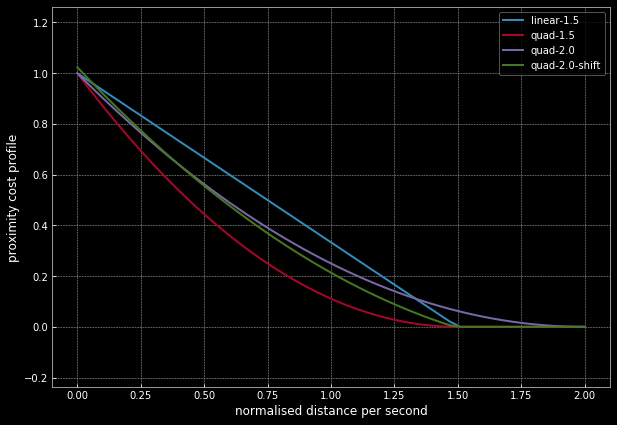

In [51]:
for k in y:
    plot(x, y[k], label=k)

axis('equal')
legend()
xlabel('normalised distance per second')
ylabel('proximity cost profile')